## Generation of the map band limited

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb

In [2]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [3]:
# nside = 512
nside = 64*2
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
nside = 64
camb_cls = camb_cls[:2*nside+1,:]

In [5]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

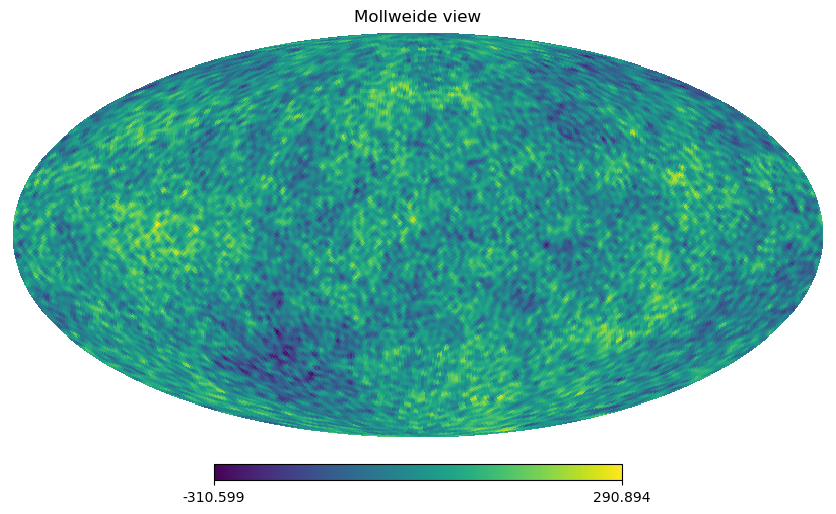

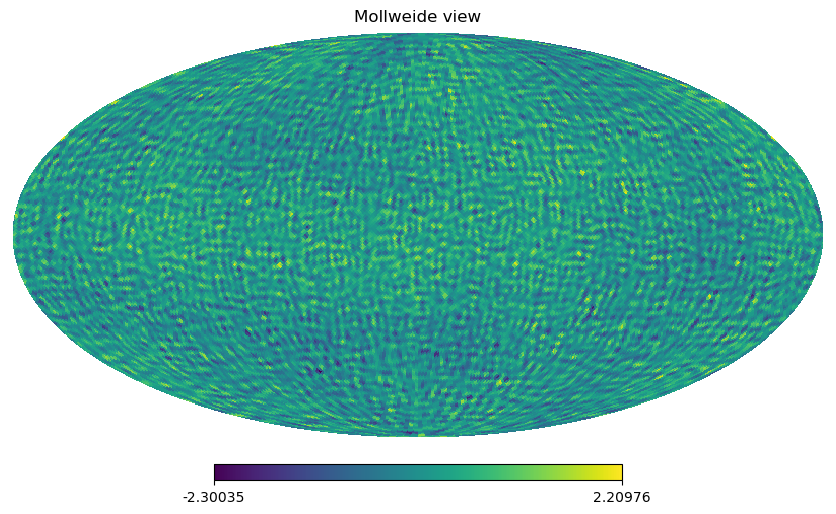

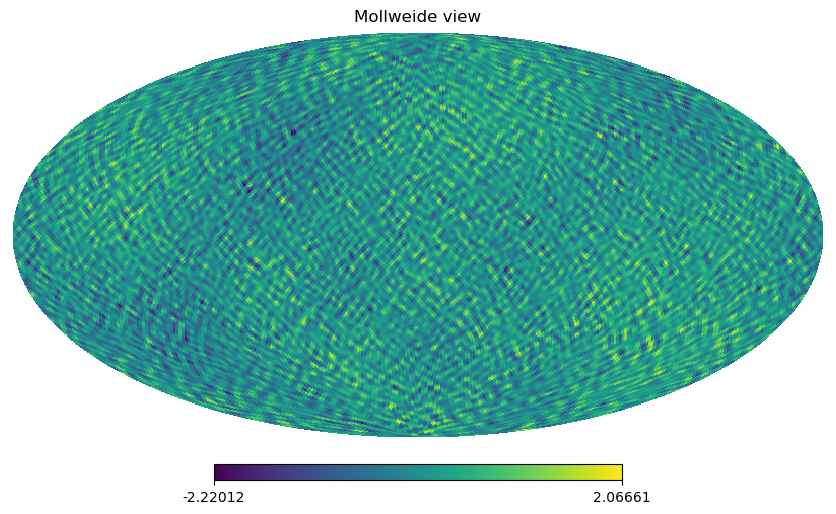

In [6]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

Text(0.5, 1.0, 'U')

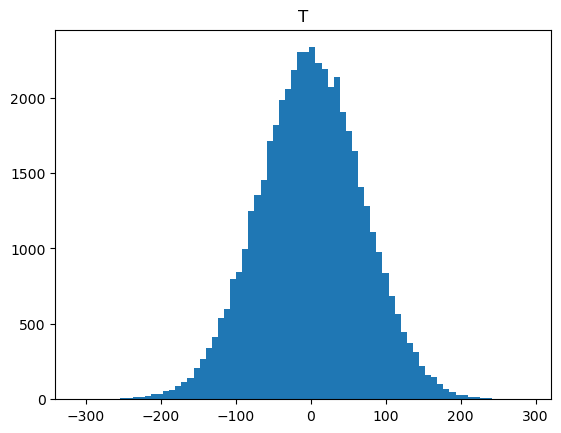

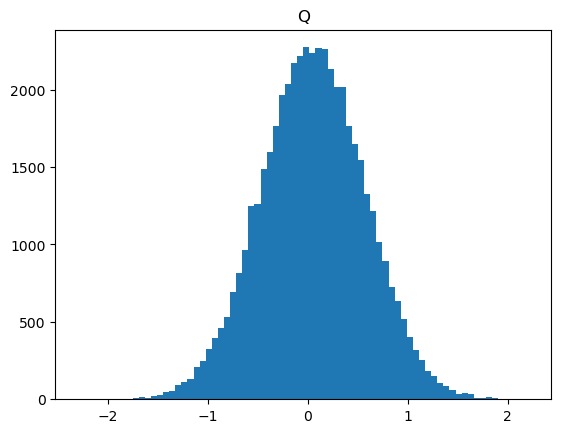

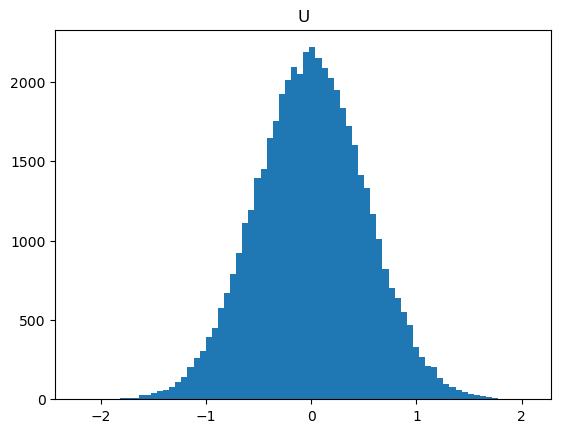

In [7]:
plt.figure()
plt.hist(maps_TQU[0], bins='rice')
plt.title('T')
plt.figure()
plt.hist(maps_TQU[1], bins='rice')
plt.title('Q')
plt.figure()
plt.hist(maps_TQU[2], bins='rice')
plt.title('U')

In [8]:
npix = 12*nside**2
fake_maps_T = np.random.normal(loc=0, scale=1, size=npix)

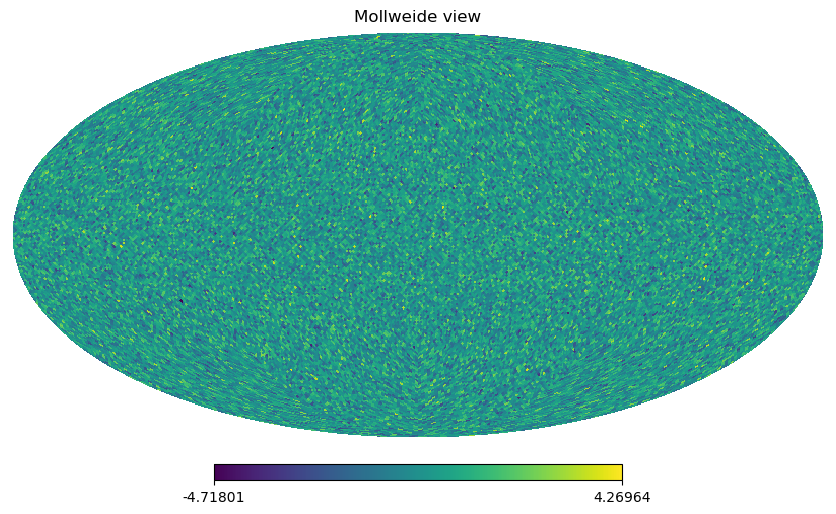

In [12]:
hp.mollview(fake_maps_T)

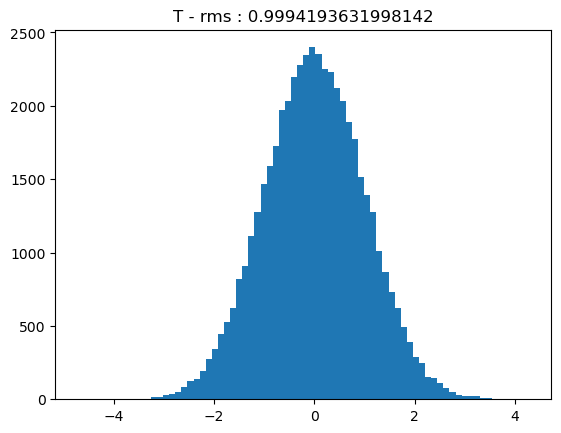

In [15]:
map_to_take_rms = fake_maps_T
rms_func_0 = lambda map_ : np.sqrt(np.sum(np.power(map_-np.mean(map_), 2))/len(map_))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

rms_T_0 = rms_func_0(map_to_take_rms)

plt.figure()
plt.hist(fake_maps_T, bins='rice')
plt.title('T - rms : {}'.format(rms_T_0))
plt.show()

In [10]:
c_ell_T = hp.anafast(fake_maps_T, lmax=2*nside)

In [23]:
hp.nside2resol(nside)**2, hp.nside2resol(nside), np.sqrt(hp.nside2resol(nside)), 1/hp.nside2resol(nside), (1/hp.nside2resol(nside))**2

(0.0002556634646476069,
 0.015989479811663883,
 0.1264495148731852,
 62.54112152357375,
 3911.39188142642)

In [21]:
1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))), (np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))), (1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2

(0.023325130288589888, 42.87221497275738, 0.0005440617029796934)

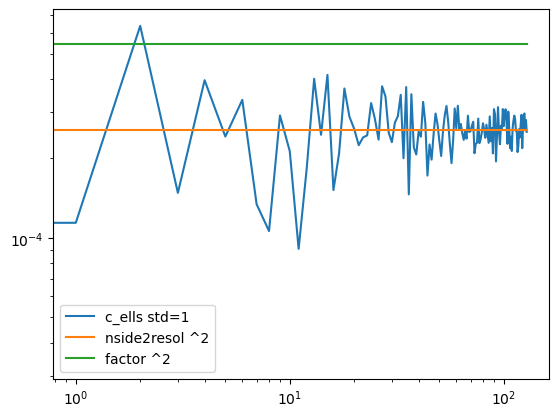

In [22]:
ells = np.arange(c_ell_T.shape[0])

plt.plot(ells, c_ell_T, label='c_ells std=1')
plt.plot([ells[0], ells[-1]], [hp.nside2resol(nside)**2, hp.nside2resol(nside)**2], label='nside2resol ^2')
plt.plot([ells[0], ells[-1]], [(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2, (1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2], label='factor ^2')

plt.loglog()
plt.legend()
plt.show()

In [69]:
c_ells = np.zeros((2*nside, 4))
c_ells[2:,:1] = (1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
c_ells[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
c_ells[2:,3] = np.sqrt(np.sqrt(np.sqrt(2)))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2

maps_white_noise_test = hp.synfast(c_ells.T, 64)

Text(0.5, 1.0, 'U - rms : 1.0427855883479955')

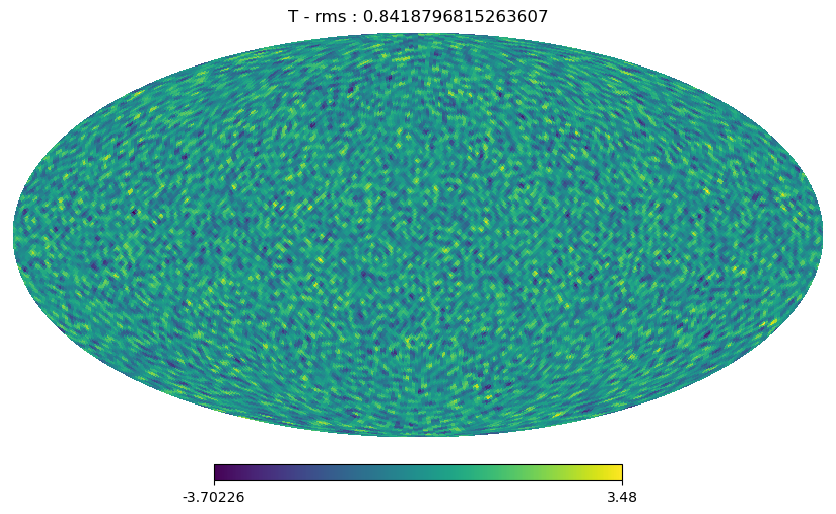

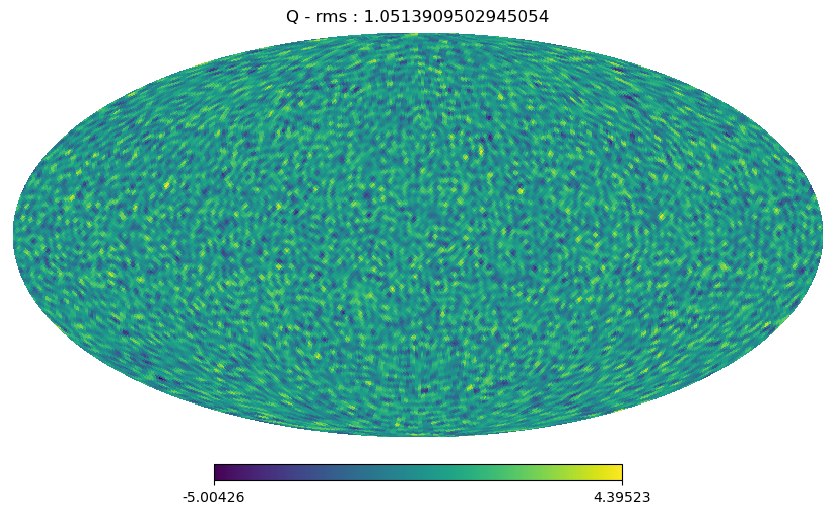

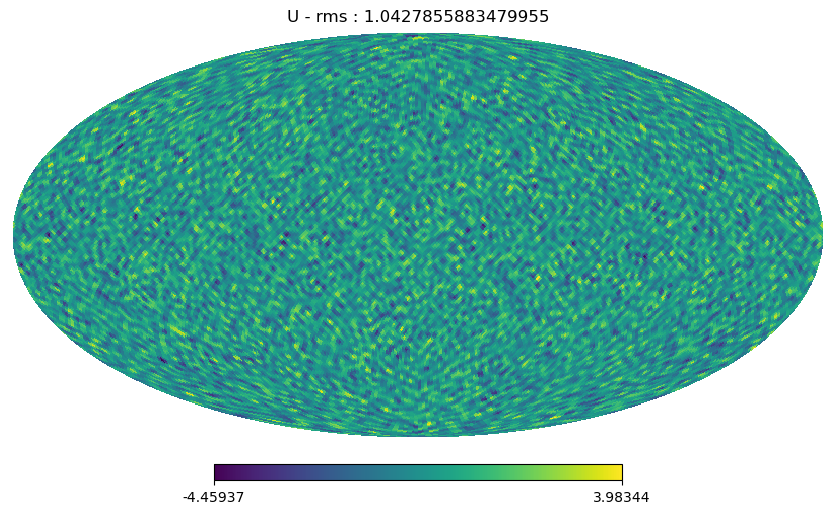

In [70]:
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

rms_T_0 = rms_func(maps_white_noise_test,0)
rms_Q_0 = rms_func(maps_white_noise_test,1)
rms_U_0 = rms_func(maps_white_noise_test,2)

hp.mollview(maps_white_noise_test[0])
plt.title('T - rms : {}'.format(rms_T_0))
hp.mollview(maps_white_noise_test[1])
plt.title('Q - rms : {}'.format(rms_Q_0))
hp.mollview(maps_white_noise_test[2])
plt.title('U - rms : {}'.format(rms_U_0))

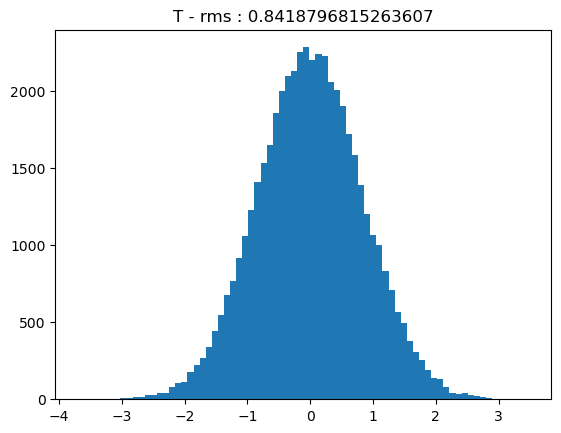

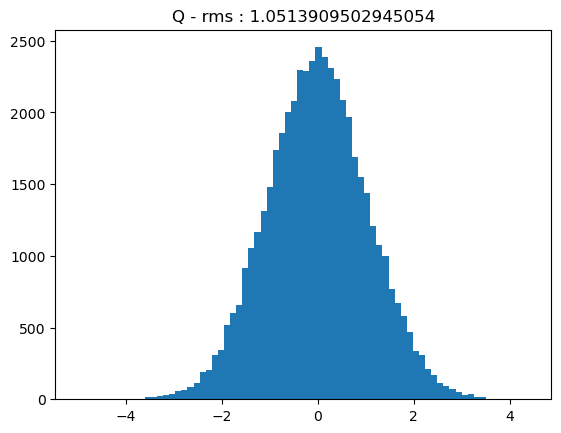

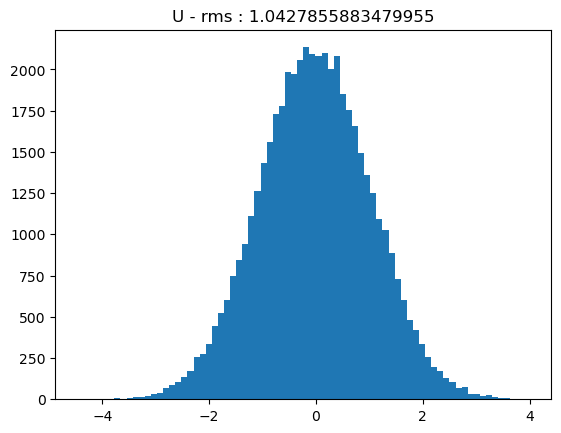

In [71]:
map_to_take_rms = fake_maps_T
rms_func_0 = lambda map_ : np.sqrt(np.sum(np.power(map_-np.mean(map_), 2))/len(map_))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

# rms_T_0 = rms_func_0(map_to_take_rms)

plt.figure()
plt.hist(maps_white_noise_test[0], bins='rice')
plt.title('T - rms : {}'.format(rms_T_0))
plt.figure()
plt.hist(maps_white_noise_test[1], bins='rice')
plt.title('Q - rms : {}'.format(rms_Q_0))
plt.figure()
plt.hist(maps_white_noise_test[2], bins='rice')
plt.title('U - rms : {}'.format(rms_U_0))
plt.show()

In [30]:
nside = 64
# lmax = 3*nside
lmax = 2*nside
# lmax = nside
# c_ells_t0 = np.zeros((2*nside, 4))
c_ells_t0 = np.zeros((lmax, 4))

normalization = np.sum(2*np.arange(lmax)+1)/(4*np.pi)
# c_ells_t0[2:,:1] = (1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,:1] = hp.nside2resol(nside)**2 #0
c_ells_t0[2:,:1] = 1/normalization
# c_ells[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,1:3] = hp.nside2resol(nside)**2
# c_ells_t0[2:,3] = np.sqrt(np.sqrt(np.sqrt(2)))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2

# maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside)
# maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside, lmax=2*nside)
maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside, lmax=min(lmax, 3*nside-1))

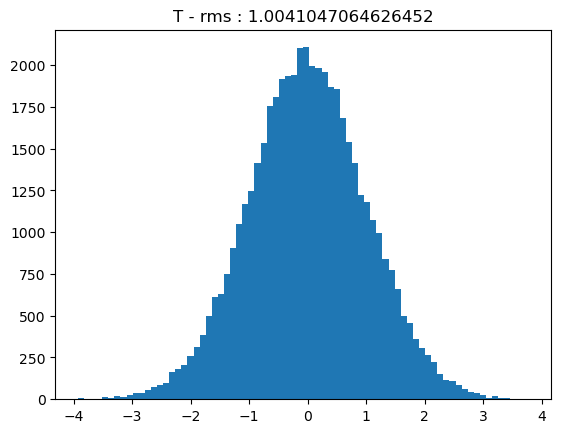

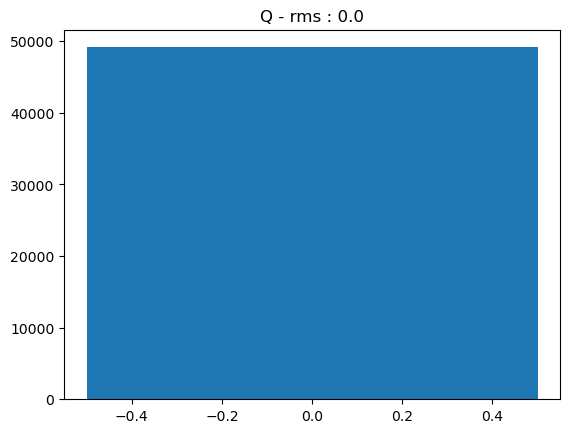

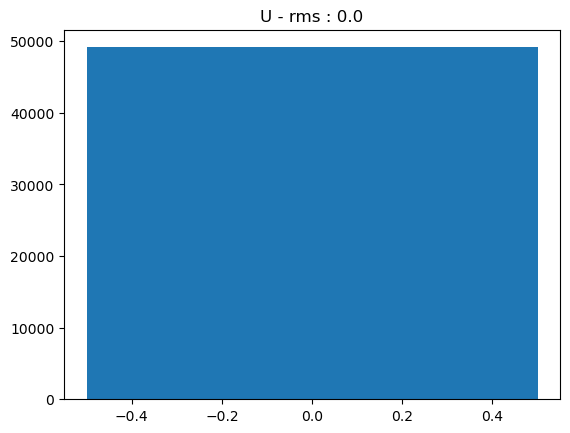

In [31]:
map_to_take_rms = maps_white_noise_test_0
rms_func_0 = lambda map_ : np.sqrt(np.sum(np.power(map_-np.mean(map_), 2))/len(map_))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

# rms_T_0 = rms_func_0(map_to_take_rms)
rms_T_0 = rms_func(map_to_take_rms, 0)
rms_Q_0 = rms_func(map_to_take_rms, 1)
rms_U_0 = rms_func(map_to_take_rms, 2)

plt.figure()
plt.hist(maps_white_noise_test_0[0], bins='rice')
plt.title('T - rms : {}'.format(rms_T_0))
plt.figure()
plt.hist(maps_white_noise_test_0[1], bins='rice')
plt.title('Q - rms : {}'.format(rms_Q_0))
plt.figure()
plt.hist(maps_white_noise_test_0[2], bins='rice')
plt.title('U - rms : {}'.format(rms_U_0))
plt.show()

In [17]:
nside = 64
# lmax = 3*nside
lmax = 2*nside
# lmax = nside
# c_ells_t0 = np.zeros((2*nside, 4))
c_ells_t0 = np.zeros((lmax, 4))

normalization = np.sum(2*np.arange(lmax)+1)/(4*np.pi)
# c_ells_t0[2:,:1] = (1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,:1] = hp.nside2resol(nside)**2 #0
c_ells_t0[2:,:1] = 1/normalization
c_ells_t0[2:,:3] = 1/normalization
c_ells_t0[2:,3] = 1/normalization
# c_ells_t0[2:,2] = 1/normalization

# c_ells[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,1:3] = (np.sqrt(2))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2
# c_ells_t0[2:,1:3] = hp.nside2resol(nside)**2
# c_ells_t0[2:,3] = np.sqrt(np.sqrt(np.sqrt(2)))*(1/(np.sum((4*np.pi)/(2*(np.arange(2*nside+1)) + 1))))**2

# maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside)
# maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside, lmax=2*nside)
maps_white_noise_test_0 = hp.synfast(c_ells_t0.T, nside, new=True, lmax=min(lmax, 3*nside-1))

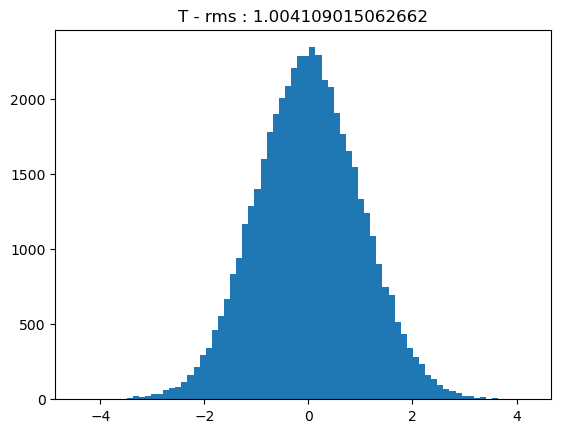

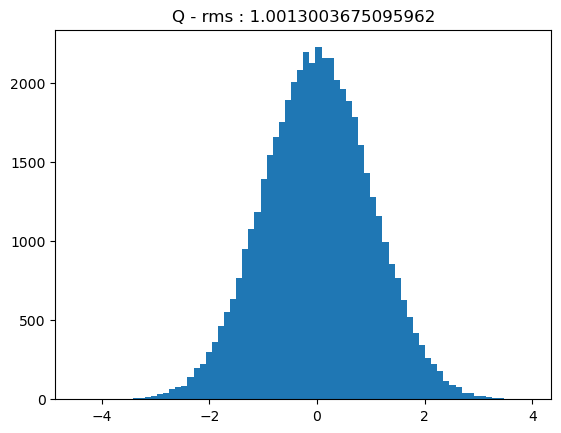

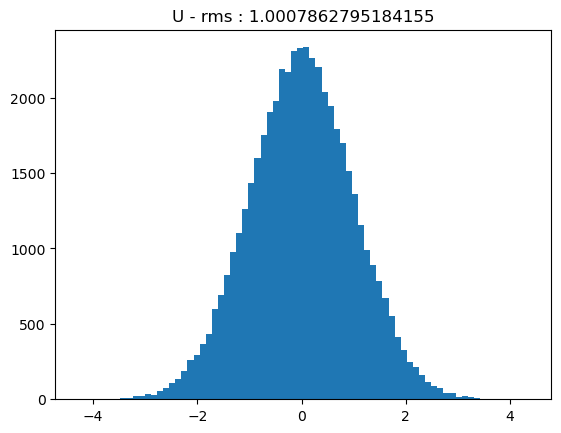

In [18]:
map_to_take_rms = maps_white_noise_test_0
rms_func_0 = lambda map_ : np.sqrt(np.sum(np.power(map_-np.mean(map_), 2))/len(map_))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

# rms_T_0 = rms_func_0(map_to_take_rms)
rms_T_0 = rms_func(map_to_take_rms, 0)
rms_Q_0 = rms_func(map_to_take_rms, 1)
rms_U_0 = rms_func(map_to_take_rms, 2)

plt.figure()
plt.hist(maps_white_noise_test_0[0], bins='rice')
plt.title('T - rms : {}'.format(rms_T_0))
plt.figure()
plt.hist(maps_white_noise_test_0[1], bins='rice')
plt.title('Q - rms : {}'.format(rms_Q_0))
plt.figure()
plt.hist(maps_white_noise_test_0[2], bins='rice')
plt.title('U - rms : {}'.format(rms_U_0))
plt.show()

In [ ]:
c_ells_resol = np.zeros((2*nside, 4))
c_ells_resol[2:,:1] =  hp.nside2resol(nside)**2
# c_ells_resol[2:,1:3] = hp.nside2resol(nside)**2
c_ells_resol[2:,1:3] = np.sqrt(np.sqrt(2))*hp.nside2resol(nside)**2
c_ells_resol[2:,3] = np.sqrt(np.sqrt(np.sqrt(2)))* hp.nside2resol(nside)**2
# c_ells_resol[2:,3] = hp.nside2resol(nside)**2

maps_white_noise_test_resol = hp.synfast(c_ells_resol.T, 64)

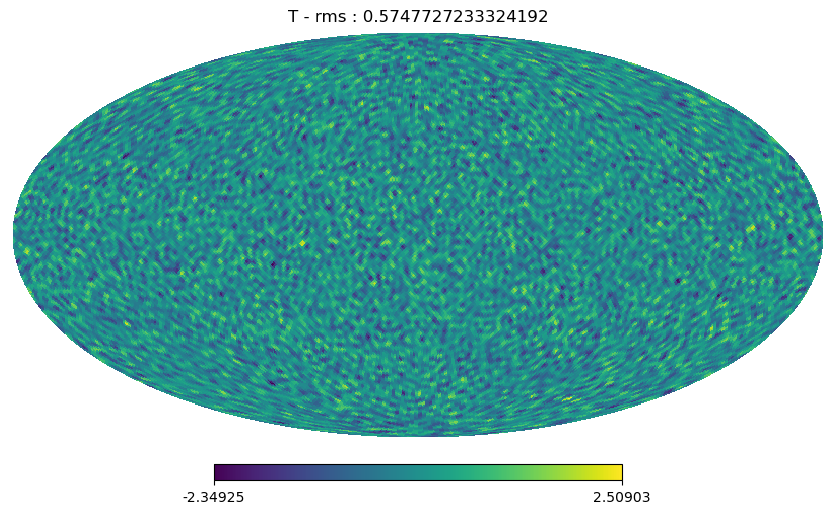

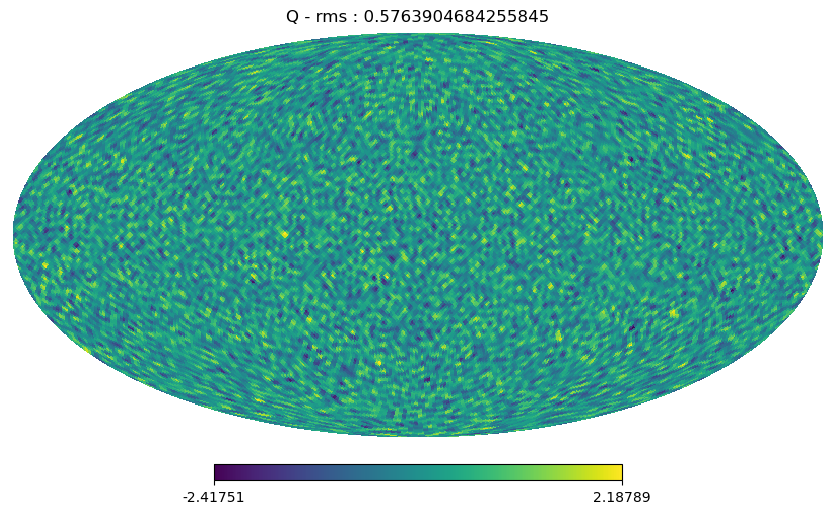

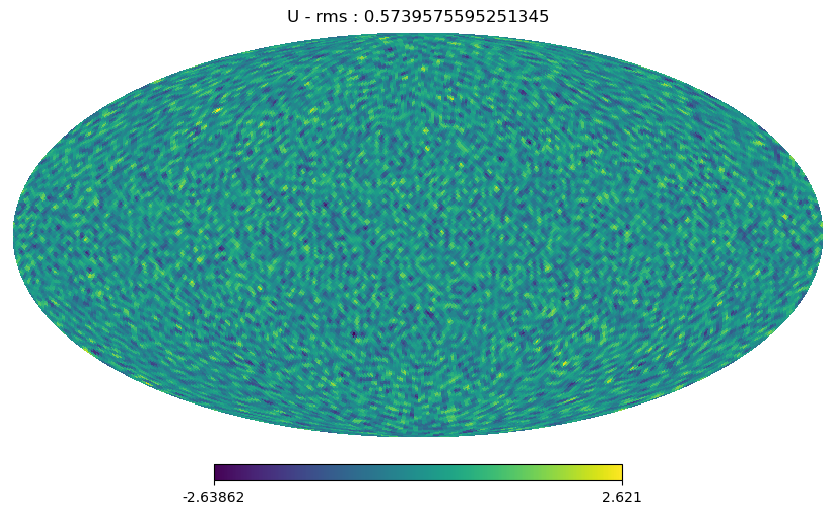

In [ ]:
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

rms_T_1 = rms_func(maps_white_noise_test_resol,0)
rms_Q_1 = rms_func(maps_white_noise_test_resol,1)
rms_U_1 = rms_func(maps_white_noise_test_resol,2)

hp.mollview(maps_white_noise_test_resol[0])
plt.title('T - rms : {}'.format(rms_T_1))
hp.mollview(maps_white_noise_test_resol[1])
plt.title('Q - rms : {}'.format(rms_Q_1))
hp.mollview(maps_white_noise_test_resol[2])
plt.title('U - rms : {}'.format(rms_U_1))
plt.show()

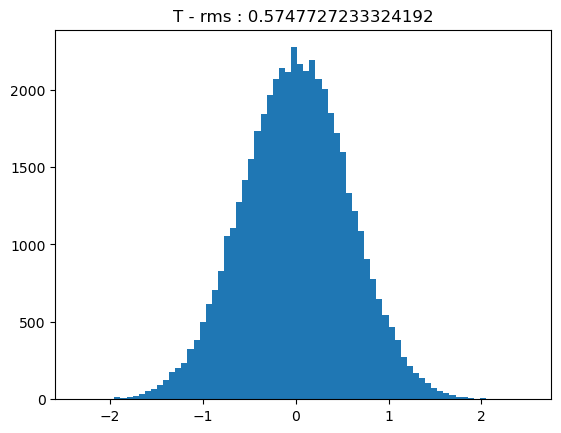

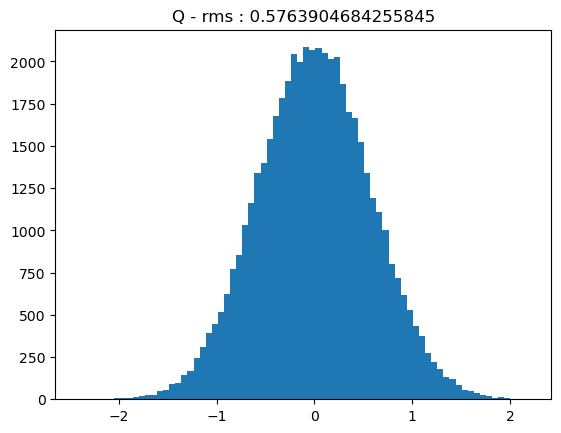

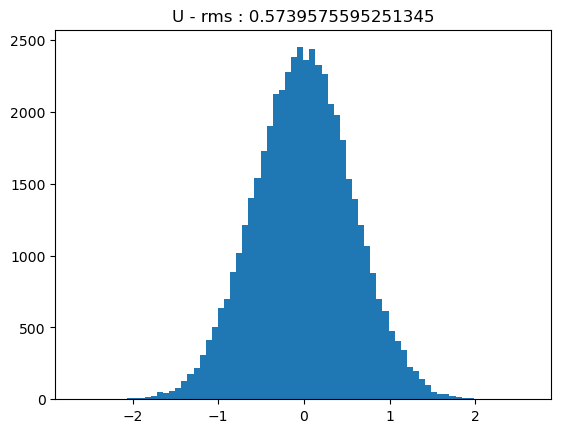

In [ ]:
map_to_take_rms = maps_white_noise_test_resol
rms_func_0 = lambda map_ : np.sqrt(np.sum(np.power(map_-np.mean(map_), 2))/len(map_))
rms_func = lambda map_, i : np.sqrt(np.sum(np.power(map_[i]-np.mean(map_[i]), 2))/len(map_[i]))

# rms_T_0 = rms_func_0(map_to_take_rms)

plt.figure()
plt.hist(maps_white_noise_test_resol[0], bins='rice')
plt.title('T - rms : {}'.format(rms_T_1))
plt.figure()
plt.hist(maps_white_noise_test_resol[1], bins='rice')
plt.title('Q - rms : {}'.format(rms_Q_1))
plt.figure()
plt.hist(maps_white_noise_test_resol[2], bins='rice')
plt.title('U - rms : {}'.format(rms_U_1))
plt.show()